<a href="https://colab.research.google.com/github/Saputoa21/ADS_2024_Saputoa/blob/master/Saputo_Introduction_to_Computational_Linguistics_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Final Project**
## Description:

In my project, I am going to compare the performance of two models on Belarusian-to-English translation tasks:

*   **First model**: WelfCrozzo/T5-L128-belarusian, specifically trained for tanslation task in this language pair.
(translation EN to BE: <extra_id_6>, translation BE to EN: <extra_id_2>)

*   **Second model**: google/mt5-small, a pretrained model that supports more languages but hasn't been trained for this translation task.

I will fine-tune the second model using **Helsinki-NLP/opus-100** dataset for the planned language pair.

My comparison will consist of:

1.   Evaluating the first model against the second model without fine-tuning on the dataset.
2.   Fine-tuning the second model using the dataset and evaluationg it.
3.   Comparison of its performance with both the first model and its initial, non-fine-tuned state.

## The Workflow of the Project

1.   Loading the Models
2.   Exploring Models' Performance on a Downstream Translation Task
3.   Loading Metrics for Evluation (BLEU, Google BLEU, SacreBLEU
4.   Loading the Dataset
5.   Comparison of the Two Models' Performance
6.   Fine-tuning Model 2
7.   Comparison of the Two Models' Performance after Fine-tuning



---



# Loading the Models

In [24]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate --upgrade
!pip install sacrebleu
!pip install transformers torch

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

### 1. Loading **WelfCrozzo/T5-L128-belarusian** (Model 1)

In [27]:
# Loading the model directly
t5_be_tokenizer = AutoTokenizer.from_pretrained("WelfCrozzo/T5-L128-belarusian")

t5_be_model = AutoModelForSeq2SeqLM.from_pretrained("WelfCrozzo/T5-L128-belarusian")

### 2. Loading **google/mt5-small** (Model 2)

In [28]:
# Loading the model directly
mt5_tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")

mt5_model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Exploring different tokenizers

For exploring the diffenrecies inthe work of tokenizers I have taken the code examples from Tutorial 5.


### 1.  **t5_be_tokenizer** from Model 1 (WelfCrozzo/T5-L128-belarusian)

In [29]:
print(t5_be_tokenizer)

T5TokenizerFast(name_or_path='WelfCrozzo/T5-L128-belarusian', vocab_size=60000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<ext

In [30]:
input_str = "Hugging face is great!"

input_tokens = mt5_tokenizer.tokenize(input_str)
print(f"Tokens of the input sequence: {input_tokens}")

input_ids = mt5_tokenizer.convert_tokens_to_ids(input_tokens)
print(f"IDs assigned to the intput sequence: {input_ids}")

decoded = mt5_tokenizer.decode(input_ids)
print(decoded)

model_inputs = mt5_tokenizer("Hugging Face is great!", return_tensors="pt")
print(model_inputs)

Tokens of the input sequence: ['▁Hu', 'gging', '▁face', '▁is', '▁great', '!']
IDs assigned to the intput sequence: [4691, 30374, 3029, 339, 3005, 309]
Hugging face is great!
{'input_ids': tensor([[ 4691, 30374, 14876,   339,  3005,   309,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [31]:
model_inputs = mt5_tokenizer(["Hugging Face is great!",
                         "The quick brown fox jumps over the lazy dog.",
                         "We are learning to fine-tune models.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(model_inputs)
print(mt5_tokenizer.pad_token, mt5_tokenizer.pad_token_id)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[  4691,  30374,  14876,    339,   3005,    309,      1,      0,      0,
              0,      0,      0,      0,      0],
        [   486,  13819,  44442,    259,  63142,  51917,    263,    910,    287,
            259, 105514,  10990,    260,      1],
        [  1306,    418,  22651,    288,   7495,    264, 118411,  33477,    260,
              1,      0,      0,      0,      0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}
<pad> 0


### 2.   **mt5_be_tokenizer** from Model 2 (google/mt5-small)

In [32]:
print(mt5_tokenizer)

T5TokenizerFast(name_or_path='google/mt5-small', vocab_size=250100, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250000: AddedToken("▁<extra_id_99>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	250001: AddedToken("▁<extra_id_98>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	250002: AddedToken("▁<extra_id_97>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	250003: Add

In [33]:
input_str = "Hugging face is great!"

tokenized_inputs = t5_be_tokenizer(input_str)
print(tokenized_inputs.input_ids)

input_tokens = t5_be_tokenizer.tokenize(input_str)
print(f"Tokens of the input sequence: {input_tokens}")

input_ids = t5_be_tokenizer.convert_tokens_to_ids(input_tokens)
print(f"IDs assigned to the intput sequence: {input_ids}")

decoded = t5_be_tokenizer.decode(input_ids)
print(decoded)

model_inputs = t5_be_tokenizer("Hugging Face is great!", return_tensors="pt")
print(model_inputs)

[34637, 10174, 3502, 135, 1511, 185, 1]
Tokens of the input sequence: ['▁Hug', 'ging', '▁face', '▁is', '▁great', '!']
IDs assigned to the intput sequence: [34637, 10174, 3502, 135, 1511, 185]
Hugging face is great!
{'input_ids': tensor([[34637, 10174, 15137,   135,  1511,   185,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [34]:
model_inputs = t5_be_tokenizer(["Hugging Face is great!",
                         "The quick brown fox jumps over the lazy dog.",
                         "We are learning to fine-tune models.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(model_inputs)
print(t5_be_tokenizer.pad_token, t5_be_tokenizer.pad_token_id)

{'input_ids': tensor([[34637, 10174, 15137,   135,  1511,   185,     1,     0,     0,     0,
             0,     0,     0,     0],
        [  138, 21766, 29280,   103, 16335, 11026,   131,   629,   106,   103,
         37036,  5893,   105,     1],
        [  353,   156, 15264,   116,  2563,   115, 19765,  3083,   105,     1,
             0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}
<pad> 0


**Note**: Since both tokenizers tokenize the strings in differently, I will use for each miodle its own tokenizer.

# Loading the Metrics

For this project, I have decided to use the two metrics:
*  **Google BLEU**: It is said to be more effective on a sentence level then BLEU score. This metric can take on values from 0 to 1, inclusive. Higher scores are better, with 0 indicating no matches, and 1 indicating a perfect match.
*   **SacreBLEU**: It is said to be more easily reproducible than just BLEU. The score can take any value between 0.0 and 100.0, inclusive, where 100.0 is a perfect match

The sources for my statements here are listed in the references below.

* I decided to get red of BLEU score as it showed in most of examples from the previous versions of the project workflow only 0, thus it was not useful for evaluation. All code cells contaning this scoe are commented
   
* Previous text about BLEU: "It is the convention metric in machine translation. BLEU’s output is always a number between 0 and 1, where values closer to 1 represent more similar texts."

In [35]:
import evaluate

bleu = evaluate.load("bleu")
google_bleu = evaluate.load("google_bleu")
sacrebleu = evaluate.load("sacrebleu")

### Exploring the metrics

In [36]:
#Example from the source for google BLEU

sentence1 = "the cat sat on the mat"
sentence2 = "the cat ate the mat"

result_bleu = bleu.compute(predictions=[sentence1], references=[[sentence2]])
result_google_bleu = google_bleu.compute(predictions=[sentence1], references=[[sentence2]])
result_sacrebleu = sacrebleu.compute(predictions=[sentence1], references=[[sentence2]])

print(result_bleu)
print(result_google_bleu)
print(result_sacrebleu)

{'bleu': 0.0, 'precisions': [0.6666666666666666, 0.4, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.2, 'translation_length': 6, 'reference_length': 5}
{'google_bleu': 0.3333333333333333}
{'score': 22.957488466614336, 'counts': [4, 2, 0, 0], 'totals': [6, 5, 4, 3], 'precisions': [66.66666666666667, 40.0, 12.5, 8.333333333333334], 'bp': 1.0, 'sys_len': 6, 'ref_len': 5}


In [37]:
# Example 2 from  the source for google BLEU

predictions = ['It is a guide to action which ensures that the rubber duck always disobeys the commands of the cat', 'he read the book because he was interested in world history']
references  = [['It is the guiding principle which guarantees the rubber duck forces never being under the command of the cat', 'It is a guide to action that ensures that the rubber duck will never heed the cat commands', 'It is the practical guide for the rubber duck army never to heed the directions of the cat'], ['he was interested in world history because he read the book']]

results_bleu = bleu.compute(predictions=predictions, references=references)
results_google_bleu = google_bleu.compute(predictions=predictions, references=references)

print(results_bleu)
print(results_google_bleu)

# SacreBLEU can not be calculated here as it requires the same number of refereces and source sentences

{'bleu': 0.6057224552983581, 'precisions': [0.9333333333333333, 0.7142857142857143, 0.5384615384615384, 0.375], 'brevity_penalty': 1.0, 'length_ratio': 1.0344827586206897, 'translation_length': 30, 'reference_length': 29}
{'google_bleu': 0.6111111111111112}


In [38]:
# Example from the source for sacre BLEU

predictions = ["hello there general kenobi",
                 "on our way to ankh morpork"]
references = [["hello there general kenobi", "hello there !"],
                 ["goodbye ankh morpork", "ankh morpork"]]

results = sacrebleu.compute(predictions=predictions, references=references)
print(results)

{'score': 39.76353643835252, 'counts': [6, 4, 2, 1], 'totals': [10, 8, 6, 4], 'precisions': [60.0, 50.0, 33.333333333333336, 25.0], 'bp': 1.0, 'sys_len': 10, 'ref_len': 7}


**Note**: BLEU score is computed separetely for each of the refeences, while google BLEU is computed once for all of the references. Sacre BLEU requires the same number for referencies to be computed

For further evaluation I am going to focus only of scores and round them till the second decimal.

### Creating Functions for Metric Calcualtions

In [39]:
# My functions

def compute_bleu_score(predictions, references):
    if isinstance(predictions, str):
        predictions = [predictions]
    if isinstance(references, str):
        references = [[references]]
    else:
        references = [ref if isinstance(ref, list) else [ref] for ref in references]
    result = bleu.compute(predictions=predictions, references=references)
    return round(result["bleu"],2)


def compute_google_bleu_score(predictions, references):
    if isinstance(predictions, str):
        predictions = [predictions]
    if isinstance(references, str):
        references = [[references]]
    else:
        references = [ref if isinstance(ref, list) else [ref] for ref in references]
    result = google_bleu.compute(predictions=predictions, references=references)
    return round(result["google_bleu"],2)


def compute_sacrebleu_score(predictions, references):
    if isinstance(predictions, str):
        predictions = [predictions]
    if isinstance(references, str):
        references = [[references]]
    else:
        references = [ref if isinstance(ref, list) else [ref] for ref in references]
    result = sacrebleu.compute(predictions=predictions, references=references)
    return round(result["score"],2)

### Testing the Functions

In [40]:
print(compute_bleu_score(sentence1, sentence2))
print(compute_google_bleu_score(sentence1, sentence2))
print(compute_sacrebleu_score(sentence1, sentence2))

0.0
0.33
22.96


In [41]:
print(compute_bleu_score(predictions, references))
print(compute_google_bleu_score(predictions, references))
print(compute_sacrebleu_score(predictions, references))

0.4
0.46
39.76


In [42]:
predicted_sentences = [
    "The cat sat on the mat.",
    "Hello, how are you?"
]

reference_sentences = [
    "The cat ate the mat.",
    "Hi, how do you do?"
]

In [43]:
print(compute_bleu_score(predicted_sentences, reference_sentences))
print(compute_google_bleu_score(predicted_sentences, reference_sentences))
print(compute_sacrebleu_score(predicted_sentences, reference_sentences))

0.0
0.32
21.14


# Loading Dataset

In [44]:
from datasets import load_dataset, DatasetDict
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForSeq2Seq


be_en_dataset = load_dataset("Helsinki-NLP/opus-100", "be-en")

README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/110k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.59M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/110k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/67312 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [45]:
def truncate(example):
    return {
        "source": example['translation']["be"],
        "translation": example['translation']["en"]
    }

In [46]:
# Splitting dataset

small_be_en_dataset = DatasetDict(
    train = be_en_dataset['train'].shuffle(seed=24).select(range(2000)).map(truncate),
    val = be_en_dataset['train'].shuffle(seed=24).select(range(200)).map(truncate),
    test = be_en_dataset['test'].shuffle(seed=24).select(range(200)).map(truncate),
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [47]:
small_be_en_dataset

DatasetDict({
    train: Dataset({
        features: ['translation', 'source'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['translation', 'source'],
        num_rows: 200
    })
    test: Dataset({
        features: ['translation', 'source'],
        num_rows: 200
    })
})

In [48]:
small_be_en_dataset["train"][:10]

{'translation': ['Auto Away',
  'Pas',
  'Yearly',
  'Insert Files - Insert new files into the project.',
  'Line',
  '1.600',
  'Last',
  'Fish Net',
  'Drizzle Fog/ Mist',
  'Select Message with Focus'],
 'source': ['Аўтаматычная адсутнасць',
  'Сту',
  'Штогод@ title: group',
  'Даданне файлаў у праект',
  'Лінейны',
  '1, 600',
  'Апошнія',
  'Зрабіць фонавым малюнкамName',
  'weather condition',
  'Пазначыць & тэкст паведамлення']}

In [49]:
small_be_en_dataset["val"][:10]

{'translation': ['Auto Away',
  'Pas',
  'Yearly',
  'Insert Files - Insert new files into the project.',
  'Line',
  '1.600',
  'Last',
  'Fish Net',
  'Drizzle Fog/ Mist',
  'Select Message with Focus'],
 'source': ['Аўтаматычная адсутнасць',
  'Сту',
  'Штогод@ title: group',
  'Даданне файлаў у праект',
  'Лінейны',
  '1, 600',
  'Апошнія',
  'Зрабіць фонавым малюнкамName',
  'weather condition',
  'Пазначыць & тэкст паведамлення']}

In [50]:
def tokenize_function(examples):
    return mt5_tokenizer(examples["source"], padding=True, truncation=True)

small_tokenized_dataset = small_be_en_dataset.map(tokenize_function, batched=True, batch_size=16)
data_collator = DataCollatorWithPadding(tokenizer=mt5_tokenizer)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [51]:
small_tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['translation', 'source', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['translation', 'source', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['translation', 'source', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})

# Evaluating the Performance on Downstream Tasks

In this part, I am going to evaluate the performance of the model on several amounts of data, such as:

1.   an unseen sentence (be-en, en-be)
2.   unseen thre sentences (be-en, en-be)
3.   validation set of the dataset for fine-tuning (32 sentences)

In [52]:
import torch

In [53]:
from datasets import load_dataset

ds = load_dataset("Helsinki-NLP/opus-100", "be-en")

In [54]:
print(ds["train"][:10])

{'translation': [{'be': '& Дадаць гэтую тэчку ў закладкі', 'en': '& Bookmark This Folder'}, {'be': 'Паказваць калёнкі', 'en': 'Check Mail'}, {'be': 'Пошук усіх файлаў, створаных ці & змененых:', 'en': 'Find all files created or & modified:'}, {'be': 'Konqueror ніколі не зробіць іэкст менш за гэты, змяняючы ўсе астатнія настаўленні', 'en': 'Konqueror will never display text smaller than this size, overriding any other settings.'}, {'be': 'Вялікі дзякуй!', 'en': 'Thank you very much!'}, {'be': '720 × 720 dpi', 'en': '720x720dpi'}, {'be': 'Федэрацыя Мiкранэзіі', 'en': 'Micronesia, Federated States Of'}, {'be': 'Ханс Петэр Бікер', 'en': 'Hans Petter Bieker'}, {'be': 'norway. kgm', 'en': 'Kristiansand'}, {'be': 'CUR( лік)', 'en': 'CUR(x)'}]}


In [55]:
print(ds)

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 67312
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [56]:
from datasets import DatasetDict

small_dataset = DatasetDict(
    train = ds['train'].shuffle(seed=24).select(range(2000)),
    val = ds['validation'].shuffle(seed=24).select(range(200)),
    test = ds['test'].shuffle(seed=24).select(range(200)),
)

In [57]:
print(small_dataset['train'][:10])

{'translation': [{'be': 'Аўтаматычная адсутнасць', 'en': 'Auto Away'}, {'be': 'Сту', 'en': 'Pas'}, {'be': 'Штогод@ title: group', 'en': 'Yearly'}, {'be': 'Даданне файлаў у праект', 'en': 'Insert Files - Insert new files into the project.'}, {'be': 'Лінейны', 'en': 'Line'}, {'be': '1, 600', 'en': '1.600'}, {'be': 'Апошнія', 'en': 'Last'}, {'be': 'Зрабіць фонавым малюнкамName', 'en': 'Fish Net'}, {'be': 'weather condition', 'en': 'Drizzle Fog/ Mist'}, {'be': 'Пазначыць & тэкст паведамлення', 'en': 'Select Message with Focus'}]}


In [58]:
print(small_dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['translation'],
        num_rows: 200
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 200
    })
})


In [59]:
from transformers import AutoTokenizer

source_lang = "be"
target_lang = "en"
prefix = "translate Belarusian to English: "

checkpoint = "google-t5/t5-small"
mt5_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = mt5_tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

tokenized = small_dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [60]:
print(tokenized)

DatasetDict({
    train: Dataset({
        features: ['translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    test: Dataset({
        features: ['translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
})


## **Model 1**

In the documanteation for the model it stands that the language pair and the translation direction is pecified with the corresponding special token ("<"extra_id_X">") before the text:

*   Belarusian → English	= "<"extra_id_2">"
*   English → Belarusian	= "<"extra_id_6">"

P.s. I put quotation marks to make the token be visible.

In [61]:
# One sentence

en_be_sentence = "<extra_id_6> Hello, how are you?"
en_be_reference = "Прывітанне, як справы?"

be_en_sentence = "<extra_id_2> Прывітанне, як справы?"
be_en_reference = "Hello, how are you?"

# Set of sentences

en_be_sentences = [
    "I am learning programming.",
    "This is an amazing model!",
    "How is the weather today?"
]

be_en_sentences = [
    "Я вучуся праграмаваць.",
    "Гэта цудоўная мадэль!",
    "Як надвор'е сёння?"
]

For evaluation I will use all thre metrics after each code cell. The reference sentences are listed above, sets of the three sentences as well as the corresponding segments in the validation (source (be) - translation (en)) are the translations of each other.

### 1.   One Sentence Analysis



In [68]:
# Tokenize input
input_ids = t5_be_tokenizer(en_be_sentence, return_tensors="pt").input_ids

# Generate translation
output_ids = t5_be_model.generate(input_ids)
translated_text = t5_be_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print result
print("Translated Text:", translated_text, "\n")

#Calculating scores
#bleu_score = compute_bleu_score(translated_text, en_be_reference)
google_bleu_score = compute_google_bleu_score(translated_text, en_be_reference)
sacrebleu_score = compute_sacrebleu_score(translated_text, en_be_reference)

print(f"One en-be sentence Scores (Model 1):\n",
      #f"BLEU = {bleu_score}\n",
      f"Google BLEU = {google_bleu_score}\n",
      f"SacreBLEU = {sacrebleu_score}")

Translated Text: Hello, як вы? 

One en-be sentence Scores (Model 1):
 Google BLEU = 0.29
 SacreBLEU = 23.64


In [69]:
# Tokenize input
input_ids = t5_be_tokenizer(be_en_sentence, return_tensors="pt").input_ids

# Generate translation
output_ids = t5_be_model.generate(input_ids)
translated_text = t5_be_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print result
print("Translated Text:", translated_text, "\n")

bleu_score = compute_bleu_score(translated_text, be_en_reference)
google_bleu_score = compute_google_bleu_score(translated_text, be_en_reference)
sacrebleu_score = compute_sacrebleu_score(translated_text, be_en_reference)

print(f"One en-be sentence Scores (Model 1):\n",
      #f"BLEU = {bleu_score}\n",
      f"Google BLEU = {google_bleu_score}\n",
      f"SacreBLEU = {sacrebleu_score}")

Translated Text: Hello how to do? 

One en-be sentence Scores (Model 1):
 Google BLEU = 0.17
 SacreBLEU = 11.51


**Note**: The first sentence was transalted partially, leaving the first English word untranslated ("Hello"), while the second sentences was translated completely, but incorrectly ("How to do?" should have been "How are you?" or "How do you do?")

### 2.   Set of Sentences Analysis


In [71]:
en_be_results = {}

for sentence in en_be_sentences:
    input_text = f"<extra_id_6> {sentence}"
    input_ids = t5_be_tokenizer.encode(input_text, return_tensors="pt")
    output_ids = t5_be_model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    translated_text = t5_be_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Original: {sentence}")
    print(f"Translated: {translated_text}\n")
    en_be_results[sentence] = translated_text

print(en_be_results, "\n")

# Extract translations and reference sentences
translated_texts = list(en_be_results.values())
reference_texts = list(be_en_sentences)

# Iterate through each sentence and compute scores
for i, (translated, reference) in enumerate(zip(translated_texts, reference_texts), 1):
    #bleu_score = compute_bleu_score(translated, reference)
    google_bleu_score = compute_google_bleu_score(translated, reference)
    sacrebleu_score = compute_sacrebleu_score(translated, reference)

    # Print the results
    print(f"en-be Sentence Set Scores (Model 1):\nSentence {i}:\n"
          #f"BLEU = {bleu_score}\n"
          f"Google BLEU = {google_bleu_score}\n"
          f"SacreBLEU = {sacrebleu_score}\n")

Original: I am learning programming.
Translated: Я навучаю праграмаванне...

Original: This is an amazing model!
Translated: Гэта дзіўная мадэль!

Original: How is the weather today?
Translated: Як сёння надвор'е?

{'I am learning programming.': 'Я навучаю праграмаванне...', 'This is an amazing model!': 'Гэта дзіўная мадэль!', 'How is the weather today?': "Як сёння надвор'е?"} 

en-be Sentence Set Scores (Model 1):
Sentence 1:
Google BLEU = 0.11
SacreBLEU = 9.65

en-be Sentence Set Scores (Model 1):
Sentence 2:
Google BLEU = 0.4
SacreBLEU = 35.36

en-be Sentence Set Scores (Model 1):
Sentence 3:
Google BLEU = 0.4
SacreBLEU = 22.59



In [ ]:
#In this cell I decided to preserve my attempts to create an optimal function for calculating the scores avross several sentences

# First draft

#for translation in en_be_results.values():
#  for true_translation in be_en_sentences:
#    bleu_score = compute_bleu_score(translation, true_translation)
#    google_bleu_score = compute_google_bleu_score(translation, true_translation)
#    sacrebleu_score = compute_sacrebleu_score(translation, true_translation)
#    print(f"en-be Sentence Set Scores (Model 1):\nBLEU = {bleu_score},\nGoogle BLEU = {google_bleu_score},\nSacreBLEU = {sacrebleu_score}\n")

#Second Draft

#bleu_score1 = compute_bleu_score(list(en_be_results.values())[0], be_en_sentences[0])
#google_bleu_score1 = compute_google_bleu_score(list(en_be_results.values())[0], be_en_sentences[0])
#sacrebleu_score1 = compute_sacrebleu_score(list(en_be_results.values())[0], be_en_sentences[0])
#print(f"en-be Sentence Set Scores (Model 1):\n1st Sentence:\nBLEU = {bleu_score1},\nGoogle BLEU = {google_bleu_score1},\nSacreBLEU = {sacrebleu_score1}\n")

#bleu_score2 = compute_bleu_score(list(en_be_results.values())[1], be_en_sentences[1])
#google_bleu_score2 = compute_google_bleu_score(list(en_be_results.values())[0], be_en_sentences[1])
#sacrebleu_score2 = compute_sacrebleu_score(list(en_be_results.values())[1], be_en_sentences[1])
#print(f"en-be Sentence Set Scores (Model 1):\n2nd Sentence:\nBLEU = {bleu_score2},\nGoogle BLEU = {google_bleu_score2},\nSacreBLEU = {sacrebleu_score2}\n")

#bleu_score3 = compute_bleu_score(list(en_be_results.values())[2], be_en_sentences[2])
#google_bleu_score3 = compute_google_bleu_score(list(en_be_results.values())[2], be_en_sentences[2])
#sacrebleu_score3 = compute_sacrebleu_score(list(en_be_results.values())[2], be_en_sentences[2])
#print(f"en-be Sentence Set Scores (Model 1):\n3rd Sentence:\nBLEU = {bleu_score3},\nGoogle BLEU = {google_bleu_score3},\nSacreBLEU = {sacrebleu_score3}")

In [72]:
be_en_results = {}

for sentence in be_en_sentences:
    input_text = f"<extra_id_2>: {sentence}"
    input_ids = t5_be_tokenizer.encode(input_text, return_tensors="pt")
    output_ids = t5_be_model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    translated_text = t5_be_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Original: {sentence}")
    print(f"Translated: {translated_text}\n")
    be_en_results[sentence] = translated_text

print(be_en_results, "\n")

# Extract translations and reference sentences
translated_texts = list(be_en_results.values())
reference_texts = list(en_be_sentences)

# Iterate through each sentence and compute scores
for i, (translated, reference) in enumerate(zip(translated_texts, reference_texts), 1):
    #bleu_score = compute_bleu_score(translated, reference)
    google_bleu_score = compute_google_bleu_score(translated, reference)
    sacrebleu_score = compute_sacrebleu_score(translated, reference)

    # Print the results
    print(f"en-be Sentence Set Scores (Model 1):\nSentence {i}:\n"
          #f"BLEU = {bleu_score}\n"
          f"Google BLEU = {google_bleu_score}\n"
          f"SacreBLEU = {sacrebleu_score}\n")

Original: Я вучуся праграмаваць.
Translated: : I learn to program...

Original: Гэта цудоўная мадэль!
Translated: : This is a wonderful model!

Original: Як надвор'е сёння?
Translated: : How is the weather today?

{'Я вучуся праграмаваць.': ': I learn to program...', 'Гэта цудоўная мадэль!': ': This is a wonderful model!', "Як надвор'е сёння?": ': How is the weather today?'} 

en-be Sentence Set Scores (Model 1):
Sentence 1:
Google BLEU = 0.08
SacreBLEU = 6.57

en-be Sentence Set Scores (Model 1):
Sentence 2:
Google BLEU = 0.27
SacreBLEU = 18.58

en-be Sentence Set Scores (Model 1):
Sentence 3:
Google BLEU = 0.82
SacreBLEU = 80.91



**Note**: I find it interesting that some of the output sentences also contain different punctuation signs, e.g. in the translation of the first sentences of the Belarusian and English set respecivelly.

In regard with the translations, all of the sentences were translated correctly, using the same parts of speech (noun "programming" as noun "прграмаванне", while verb "праграмаваць" as verb "to program" (American English)) or synonymes ("wonderful" as "amazing" and "дзіўная" as "цудоўная").

Regarding the scores, I would not score the translations as a human so low as they are complete and the meaning is transmitted correctly.

For further multisentece evaluations I will create after each code cell a separate dictionary, whrere I will store all of the scores to visualise them later.

### 3.   Validation set

*Belarusian to English*

In [81]:
val_set = small_tokenized_dataset["val"]["source"]

def translate_text(text, direction="<extra_id_2>"):  # Belarusian → English
    input_text = f"{direction} {text}"
    input_ids = t5_be_tokenizer(input_text, return_tensors="pt").input_ids

    # Generate translation
    output_ids = t5_be_model.generate(input_ids, max_length=128)
    translated_text = t5_be_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return translated_text

translated_sentences = []
for sentence in val_set:
    translated = translate_text(sentence, direction="<extra_id_2>")  # Belarusian → English
    translated_sentences.append(translated)

for i in range(15):
    print(f"Original: {val_set[i]}")
    print(f"Translated: {translated_sentences[i]}\n")

print(len(translated_sentences))

Original: Аўтаматычная адсутнасць
Translated: Motormatic absence

Original: Сту
Translated: Stu

Original: Штогод@ title: group
Translated: Every year@ title: group

Original: Даданне файлаў у праект
Translated: The addition of files to the project

Original: Лінейны
Translated: Lense

Original: 1, 600
Translated: 1, 600

Original: Апошнія
Translated: The last

Original: Зрабіць фонавым малюнкамName
Translated: To make a background drawing ofName

Original: weather condition
Translated: weather condition

Original: Пазначыць & тэкст паведамлення
Translated: The information text will be considered

Original: Праграма зараз у аўтаномным рэжыму. Ці вы хочаце злучыцца, каб выканаць гэтае дзеянне?
Translated: The program is now in the autonomous regime... Do you want to connect to fulfill this effect?

Original: Узровень:
Translated: Consection:

Original: Трынідад і Табага
Translated: Trinidad and Taba

Original: Стварыць тэчку...
Translated: Keep a leak...

Original: Кіруйце касмічным кар

In [113]:
# Overall scores for the whole validation set

translated_texts = translated_sentences
reference_texts = val_set = small_tokenized_dataset["val"]["translation"]

overall_google_bleu_score_be_en = compute_google_bleu_score(translated_texts, reference_texts)
overall_sacrebleu_score_be_en = compute_sacrebleu_score(translated_texts, reference_texts)

print(overall_google_bleu_score_be_en)
print(overall_sacrebleu_score_be_en)

0.16
13.06


In [114]:
#Scores for each of the 15 sentences from the validation set

model1_result_dict_val_be_en = {}

#model1_result_dict_val_be_en['bleu_score_list'] = []
model1_result_dict_val_be_en['google_bleu_score_list'] = []
model1_result_dict_val_be_en['sacrebleu_score_list'] = []

# Extract translations and reference sentences
translated_texts = translated_sentences
reference_texts = val_set = small_tokenized_dataset["val"]["translation"]

# Iterate through each sentence and compute scores
for i, (translated, reference) in enumerate(zip(translated_texts, reference_texts), 1):
    #bleu_score = compute_bleu_score(translated, reference)
    google_bleu_score = compute_google_bleu_score(translated, reference)
    sacrebleu_score = compute_sacrebleu_score(translated, reference)

    #model1_result_dict_val_be_en['bleu_score_list'].append(bleu_score)
    model1_result_dict_val_be_en['google_bleu_score_list'].append(google_bleu_score)
    model1_result_dict_val_be_en['sacrebleu_score_list'].append(sacrebleu_score)

    print(f"be-en Validation Set Scores (Model 1):\nSentence {i}:\n"
          #f"BLEU = {bleu_score}\n"
          f"Google BLEU = {google_bleu_score}\n"
          f"SacreBLEU = {sacrebleu_score}\n")
    i += 1
    if i == 16:
      break

be-en Validation Set Scores (Model 1):
Sentence 1:
Google BLEU = 1.0
SacreBLEU = 0.0

be-en Validation Set Scores (Model 1):
Sentence 2:
Google BLEU = 0.0
SacreBLEU = 0.0

be-en Validation Set Scores (Model 1):
Sentence 3:
Google BLEU = 0.0
SacreBLEU = 0.0

be-en Validation Set Scores (Model 1):
Sentence 4:
Google BLEU = 0.05
SacreBLEU = 4.46

be-en Validation Set Scores (Model 1):
Sentence 5:
Google BLEU = 0.0
SacreBLEU = 0.0

be-en Validation Set Scores (Model 1):
Sentence 6:
Google BLEU = 0.0
SacreBLEU = 0.0

be-en Validation Set Scores (Model 1):
Sentence 7:
Google BLEU = 0.0
SacreBLEU = 0.0

be-en Validation Set Scores (Model 1):
Sentence 8:
Google BLEU = 0.33
SacreBLEU = 0.0

be-en Validation Set Scores (Model 1):
Sentence 9:
Google BLEU = 0.1
SacreBLEU = 15.97

be-en Validation Set Scores (Model 1):
Sentence 10:
Google BLEU = 0.1
SacreBLEU = 15.97

be-en Validation Set Scores (Model 1):
Sentence 11:
Google BLEU = 0.03
SacreBLEU = 2.13

be-en Validation Set Scores (Model 1):
Sent

In [115]:
# To check if the function works well
#print(model1_result_dict_val_be_en['bleu_score_list'])
print(model1_result_dict_val_be_en['google_bleu_score_list'])
print(model1_result_dict_val_be_en['sacrebleu_score_list'])

#print(len(model1_result_dict_val_be_en['bleu_score_list']))
print(len(model1_result_dict_val_be_en['google_bleu_score_list']))
print(len(model1_result_dict_val_be_en['sacrebleu_score_list']))

[1.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.33, 0.1, 0.1, 0.03, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 4.46, 0.0, 0.0, 0.0, 0.0, 15.97, 15.97, 2.13, 0.0, 0.0, 0.0, 0.0]
15
15


*English to Belarusian*

In [116]:
val_set = small_tokenized_dataset["val"]["translation"]

def translate_text(text, direction="<extra_id_6>"):  # English → Belarusian
    input_text = f"{direction} {text}"
    input_ids = t5_be_tokenizer(input_text, return_tensors="pt").input_ids

    # Generate translation
    output_ids = t5_be_model.generate(input_ids, max_length=128)
    translated_text = t5_be_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return translated_text

translated_sentences = []
for sentence in val_set:
    translated = translate_text(sentence, direction="<extra_id_6>")  #  English → Belarusian
    translated_sentences.append(translated)

# Print some results
for i in range(16):
    print(f"Original: {val_set[i]}")
    print(f"Translated: {translated_sentences[i]}\n")

Original: Auto Away
Translated: Auto Away

Original: Pas
Translated: Пас

Original: Yearly
Translated: Годна

Original: Insert Files - Insert new files into the project.
Translated: Інсерт Філіс - Інсерт новыя файлы ў праект...

Original: Line
Translated: Лінія

Original: 1.600
Translated: медыятэхнічны і інш

Original: Last
Translated: Мінулае

Original: Fish Net
Translated: Рыба Net

Original: Drizzle Fog/ Mist
Translated: Друзье Фог/місты

Original: Select Message with Focus
Translated: Адбіраць Пасланне з Focus

Original: This application is currently in offline mode. Do you want to connect in order to carry out this operation?
Translated: Гэтае прыкладанне зараз у афлайн-рэжыме... Жадаешся падключыцца, каб правесці гэтую аперацыю?

Original: Level:
Translated:  Level:

Original: Trinidad And Tobago
Translated: Трынідад І Табага

Original: Open at the given position in the bookmarks file
Translated: Адкрыцца на дадзенай пасадзе ў файце закладак

Original: Fly your ship in a 4d envi

In [117]:
# Overall scores for the whole validation set

translated_texts = translated_sentences
reference_texts = val_set = small_tokenized_dataset["val"]["source"]

overall_google_bleu_score_en_be = compute_google_bleu_score(translated_texts, reference_texts)
overall_sacrebleu_score_en_be = compute_sacrebleu_score(translated_texts, reference_texts)

print(overall_google_bleu_score_en_be)
print(overall_sacrebleu_score_en_be)

0.14
13.17


In [118]:
#Scores for each of the 15 sentences from the validation set

model1_result_dict_val_en_be = {}

#model1_result_dict_val_en_be['bleu_score_list'] = []
model1_result_dict_val_en_be['google_bleu_score_list'] = []
model1_result_dict_val_en_be['sacrebleu_score_list'] = []

# Extract translations and reference sentences
translated_texts = translated_sentences
reference_texts = val_set = small_tokenized_dataset["val"]["source"]

# Iterate through each sentence and compute scores
for i, (translated, reference) in enumerate(zip(translated_texts, reference_texts), 1):
    bleu_score = compute_bleu_score(translated, reference)
    google_bleu_score = compute_google_bleu_score(translated, reference)
    sacrebleu_score = compute_sacrebleu_score(translated, reference)

    #model1_result_dict_val_en_be['bleu_score_list'].append(bleu_score)
    model1_result_dict_val_en_be['google_bleu_score_list'].append(google_bleu_score)
    model1_result_dict_val_en_be['sacrebleu_score_list'].append(sacrebleu_score)

    print(f"en-be Validation Set Scores (Model 1):\nSentence {i}:\n"
          #f"BLEU = {bleu_score}\n"
          f"Google BLEU = {google_bleu_score}\n"
          f"SacreBLEU = {sacrebleu_score}\n")
    i += 1
    if i == 16:
      break

en-be Validation Set Scores (Model 1):
Sentence 1:
Google BLEU = 0.0
SacreBLEU = 0.0

en-be Validation Set Scores (Model 1):
Sentence 2:
Google BLEU = 0.0
SacreBLEU = 0.0

en-be Validation Set Scores (Model 1):
Sentence 3:
Google BLEU = 0.0
SacreBLEU = 0.0

en-be Validation Set Scores (Model 1):
Sentence 4:
Google BLEU = 0.03
SacreBLEU = 3.75

en-be Validation Set Scores (Model 1):
Sentence 5:
Google BLEU = 0.0
SacreBLEU = 0.0

en-be Validation Set Scores (Model 1):
Sentence 6:
Google BLEU = 0.0
SacreBLEU = 0.0

en-be Validation Set Scores (Model 1):
Sentence 7:
Google BLEU = 0.0
SacreBLEU = 0.0

en-be Validation Set Scores (Model 1):
Sentence 8:
Google BLEU = 0.0
SacreBLEU = 0.0

en-be Validation Set Scores (Model 1):
Sentence 9:
Google BLEU = 0.0
SacreBLEU = 0.0

en-be Validation Set Scores (Model 1):
Sentence 10:
Google BLEU = 0.0
SacreBLEU = 0.0

en-be Validation Set Scores (Model 1):
Sentence 11:
Google BLEU = 0.14
SacreBLEU = 7.66

en-be Validation Set Scores (Model 1):
Sentence 

In [119]:
# To check if the function works well
# print(model1_result_dict_val_en_be['bleu_score_list'])
print(model1_result_dict_val_en_be['google_bleu_score_list'])
print(model1_result_dict_val_en_be['sacrebleu_score_list'])

# print(len(model1_result_dict_val_en_be['bleu_score_list']))
print(len(model1_result_dict_val_en_be['google_bleu_score_list']))
print(len(model1_result_dict_val_en_be['sacrebleu_score_list']))

[0.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14, 0.33, 0.33, 0.0, 0.06]
[0.0, 0.0, 0.0, 3.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.66, 0.0, 0.0, 0.0, 8.75]
15
15


**Note**: I think, the score are so low, especially BLEU score, because the reference sentences of the validation set are much longer than the segments used for tranlations. Additionally, the daataset is not absolutely "clean" as some source segments in Belarusian contain English words or are entirely in English.

Nevertheless, the parts or separate words from them, e.g. "пакуль" ("while", "until") were translated in most cases correctly omitting incorrect coresspondences in the dataset.

### Visualisation of Metrics Outputs

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [92]:
# sentences = [f"Sentence {i+1}" for i in range(16)]

# bleu_scores = model1_result_dict_val_en_be['bleu_score_list']
# google_bleu_scores = model1_result_dict_val_en_be['google_bleu_score_list']

# # Create a DataFrame to hold the scores
# df = pd.DataFrame({
#     'Sentence': sentences,
#     'BLEU': bleu_scores,
#     'Google BLEU': google_bleu_scores,
# })

# # Plotting
# plt.figure(figsize=(10, 6))

# # Plot each score type
# plt.plot(df['Sentence'], df['BLEU'], label='BLEU', marker='o', linestyle='-', color='b')
# plt.plot(df['Sentence'], df['Google BLEU'], label='Google BLEU', marker='o', linestyle='-', color='g')

# # Adding labels and title
# plt.xlabel('Sentence')
# plt.ylabel('Score')
# plt.title('Comparison of BLEU and Google BLEU Scores Across Sentences in a the Validation Set (en - be)')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Add a legend
# plt.legend()

# # Show plot
# plt.tight_layout()
# plt.show()

In [93]:
# sentences = [f"Sentence {i+1}" for i in range(16)]

# bleu_scores = model1_result_dict_val_be_en['bleu_score_list']
# google_bleu_scores = model1_result_dict_val_be_en['google_bleu_score_list']

# # Create a DataFrame to hold the scores
# df = pd.DataFrame({
#     'Sentence': sentences,
#     'BLEU': bleu_scores,
#     'Google BLEU': google_bleu_scores,
# })

# # Plotting
# plt.figure(figsize=(10, 6))

# # Plot each score type
# plt.plot(df['Sentence'], df['BLEU'], label='BLEU', marker='o', linestyle='-', color='b')
# plt.plot(df['Sentence'], df['Google BLEU'], label='Google BLEU', marker='o', linestyle='-', color='g')

# # Adding labels and title
# plt.xlabel('Sentence')
# plt.ylabel('Score')
# plt.title('Comparison of BLEU and Google BLEU Scores Across Sentences in the Validation Set (be - en)')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Add a legend
# plt.legend()

# # Show plot
# plt.tight_layout()
# plt.show()

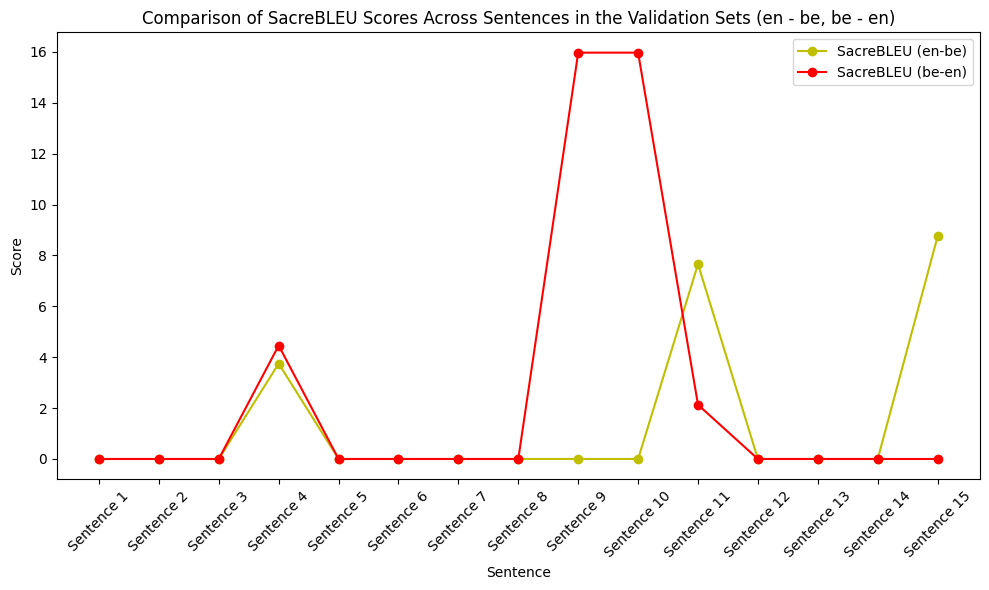

In [124]:
sentences = [f"Sentence {i+1}" for i in range(15)]
sacrebleu_scores_en_be = model1_result_dict_val_en_be['sacrebleu_score_list']
sacrebleu_scores_be_en = model1_result_dict_val_be_en['sacrebleu_score_list']

# Create a DataFrame to hold the scores
df = pd.DataFrame({
    'Sentence': sentences,
    'SacreBLEU (en-be)': sacrebleu_scores_en_be,
    'SacreBLEU (be-en)': sacrebleu_scores_be_en,
})

# Plotting
plt.figure(figsize=(10, 6))

# Plot each score type
plt.plot(df['Sentence'], df['SacreBLEU (en-be)'], label='SacreBLEU (en-be)', marker='o', linestyle='-', color='y')
plt.plot(df['Sentence'], df['SacreBLEU (be-en)'], label='SacreBLEU (be-en)', marker='o', linestyle='-', color='r')

# Adding labels and title
plt.xlabel('Sentence')
plt.ylabel('Score')
plt.title('Comparison of SacreBLEU Scores Across Sentences in the Validation Sets (en - be, be - en)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

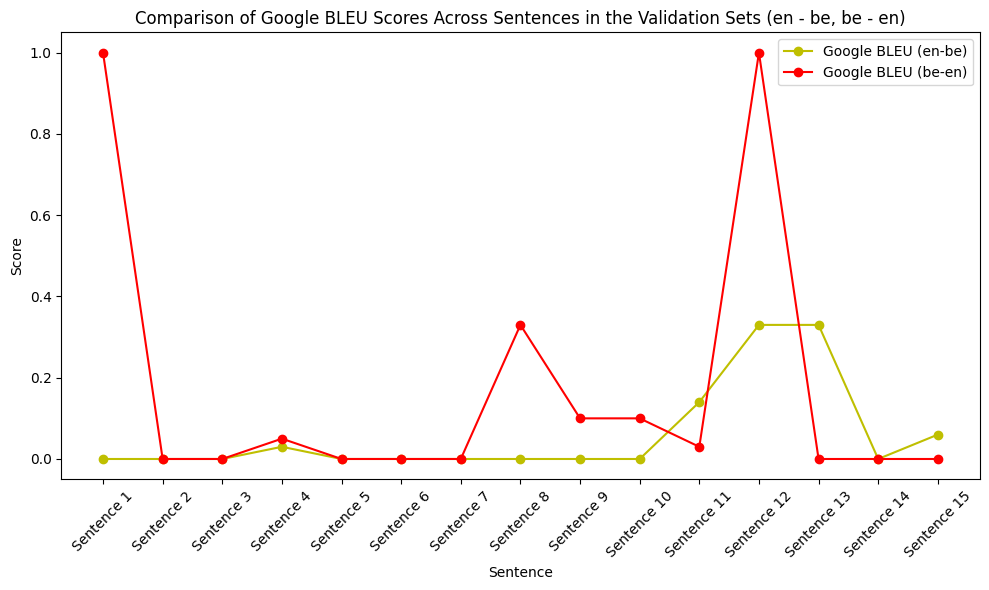

In [125]:
sentences = [f"Sentence {i+1}" for i in range(15)]
google_bleu_scores_en_be = model1_result_dict_val_en_be['google_bleu_score_list']
google_bleu_scores_be_en = model1_result_dict_val_be_en['google_bleu_score_list']

# Create a DataFrame to hold the scores
df = pd.DataFrame({
    'Sentence': sentences,
    'Google BLEU (en-be)': google_bleu_scores_en_be,
    'Google BLEU (be-en)': google_bleu_scores_be_en,
})

# Plotting
plt.figure(figsize=(10, 6))

# Plot each score type
plt.plot(df['Sentence'], df['Google BLEU (en-be)'], label='Google BLEU (en-be)', marker='o', linestyle='-', color='y')
plt.plot(df['Sentence'], df['Google BLEU (be-en)'], label='Google BLEU (be-en)', marker='o', linestyle='-', color='r')

# Adding labels and title
plt.xlabel('Sentence')
plt.ylabel('Score')
plt.title('Comparison of Google BLEU Scores Across Sentences in the Validation Sets (en - be, be - en)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

**Note**: .......

## **Model 2**

Thanks to the help of my professor, it has been proved that google mt5 i not able to used in the yero-shot manner as the precious model an, therefore, is not able perform the downstream task without a proper fine-tuning.

In this section, I will just show several examples of the model's output of one sentence analysis without fine-tunging, while in the next one I will train further it on the dataset.

I have not found any specifications about the specific tokens to use in this model for selection of the language pair and the translation direction, so I am using here a prompt discribing the task before the text to translate.    

In [126]:
#One sentence

mt5_en_be_sentence = "Translate from English to Belarusian: Hello, how are you?"

mt5_be_en_sentence = "Translate from Belarusian to English: Прывітанне, як справы?"

In [127]:
# Tokenize input
input_ids = mt5_tokenizer(mt5_en_be_sentence, return_tensors="pt").input_ids

# Generate translation
output_ids = mt5_model.generate(input_ids)
translated_text = mt5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print result
print("Translated Text:", translated_text)

Translated Text: 


In [128]:
# Tokenize input
input_ids = mt5_tokenizer(mt5_be_en_sentence, return_tensors="pt").input_ids

# Generate translation
output_ids = mt5_model.generate(input_ids)
translated_text = mt5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print result
print("Translated Text:", translated_text)

Translated Text: 


**Note**: Unfortunalelly, none of the sentences and sets were translated, but got only <extra_id_O> as output, which should mean that the model is not trained on such tasks, although it was said on the model description page on HuggingFace and it should solve them after fine-tuning. Because of this outnput I did not add any metrics calcualtions.

**Source**: https://www.aimodels.fyi/models/huggingFace/mt5-small-google

# Fine-tuning Model 2

For fine-tuning the Model 2, I used another preprocessing of the dataset, although the number of samples for eacj of the sets is preserved.  

In [129]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [130]:
from datasets import load_dataset

ds = load_dataset("Helsinki-NLP/opus-100", "be-en")

In [131]:
print(ds["train"][:10])

{'translation': [{'be': '& Дадаць гэтую тэчку ў закладкі', 'en': '& Bookmark This Folder'}, {'be': 'Паказваць калёнкі', 'en': 'Check Mail'}, {'be': 'Пошук усіх файлаў, створаных ці & змененых:', 'en': 'Find all files created or & modified:'}, {'be': 'Konqueror ніколі не зробіць іэкст менш за гэты, змяняючы ўсе астатнія настаўленні', 'en': 'Konqueror will never display text smaller than this size, overriding any other settings.'}, {'be': 'Вялікі дзякуй!', 'en': 'Thank you very much!'}, {'be': '720 × 720 dpi', 'en': '720x720dpi'}, {'be': 'Федэрацыя Мiкранэзіі', 'en': 'Micronesia, Federated States Of'}, {'be': 'Ханс Петэр Бікер', 'en': 'Hans Petter Bieker'}, {'be': 'norway. kgm', 'en': 'Kristiansand'}, {'be': 'CUR( лік)', 'en': 'CUR(x)'}]}


In [132]:
print(ds)

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 67312
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [133]:
from datasets import DatasetDict

small_dataset = DatasetDict(
    train = ds['train'].shuffle(seed=24).select(range(2000)),
    val = ds['validation'].shuffle(seed=24).select(range(200)),
    test = ds['test'].shuffle(seed=24).select(range(200)),
)

In [134]:
print(small_dataset['train'][:10])

{'translation': [{'be': 'Аўтаматычная адсутнасць', 'en': 'Auto Away'}, {'be': 'Сту', 'en': 'Pas'}, {'be': 'Штогод@ title: group', 'en': 'Yearly'}, {'be': 'Даданне файлаў у праект', 'en': 'Insert Files - Insert new files into the project.'}, {'be': 'Лінейны', 'en': 'Line'}, {'be': '1, 600', 'en': '1.600'}, {'be': 'Апошнія', 'en': 'Last'}, {'be': 'Зрабіць фонавым малюнкамName', 'en': 'Fish Net'}, {'be': 'weather condition', 'en': 'Drizzle Fog/ Mist'}, {'be': 'Пазначыць & тэкст паведамлення', 'en': 'Select Message with Focus'}]}


In [135]:
print(small_dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['translation'],
        num_rows: 200
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 200
    })
})


In [146]:
from transformers import AutoTokenizer

source_lang = "be"
target_lang = "en"
prefix = "translate Belarusian to English: "

checkpoint = "google-t5/t5-small"
mt5_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = mt5_tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

tokenized = small_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [156]:
from transformers import DataCollatorForSeq2Seq
import evaluate

data_collator = DataCollatorForSeq2Seq(tokenizer=mt5_tokenizer, model=checkpoint)
sacrebleu_metric = evaluate.load("sacrebleu")
google_bleu_metric = evaluate.load("google_bleu")

In [159]:
import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = mt5_tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, mt5_tokenizer.pad_token_id)
    decoded_labels = mt5_tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    sacrebleu_result = sacrebleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    google_bleu_result = google_bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    prediction_lens = [np.count_nonzero(pred != mt5_tokenizer.pad_token_id) for pred in preds]
    return {
        "sacrebleu": sacrebleu_result["score"],
        "google_bleu": google_bleu_result["google_bleu"],
        "gen_len": np.mean(prediction_lens),
    }
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [160]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [154]:
training_args = Seq2SeqTrainingArguments(
    output_dir="fine_tuned_mt5_be_en_translation_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    #save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True, #change to bf16=True for XPU
    report_to='none',
    seed=224
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["val"],
    processing_class=mt5_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [155]:
trainer.train()

Epoch,Training Loss,Validation Loss


UnboundLocalError: cannot access local variable 'result' where it is not associated with a value

In [ ]:
results = trainer.predict(tokenized['val'])

print(results)

In [ ]:
# Complete the code here to load one of the checkpoints for the fine-tuned model
fine_tuned_mt5_model = AutoModelForSeq2SeqLM.from_pretrained("path")

model_inputs = mt5_tokenizer(tokenized['val'], padding=True, truncation=True, return_tensors='pt')
outputs = fine_tuned_mt5_model(**model_inputs, output_hidden_states=True)

another try

In [ ]:
from transformers import DataCollatorForSeq2Seq
import evaluate

data_collator = DataCollatorForSeq2Seq(tokenizer=mt5_tokenizer, model=checkpoint)
bleu = evaluate.load("bleu")
google_bleu = evaluate.load("google_bleu")
sacrebleu = evaluate.load("sacrebleu")

In [ ]:
import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = mt5_tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, mt5_tokenizer.pad_token_id)
    decoded_labels = mt5_tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    sacrebleu_result = sacrebleu.compute(predictions=decoded_preds, references=decoded_labels)
    #bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    google_bleu_result = google_bleu.compute(predictions=decoded_preds, references=decoded_labels)

    prediction_lens = [np.count_nonzero(pred != mt5_tokenizer.pad_token_id) for pred in preds ]

    result = {
        #"bleu": bleu_result,
        "sacrebleu": sacrebleu_result,
        "gleu": google_bleu,
        "gen_len": np.mean(prediction_lens),
    }
    return result

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="fine_tuned_mt5_be_en_translation_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    #save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True, #change to bf16=True for XPU
    report_to='none',
    seed=224
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["val"],
    processing_class=mt5_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


TypeError: type dict doesn't define __round__ method

# Evaluating Model 2

In this section, I an going to evaluate my model on the test set and in the zero/shot manner as I had done so wuth Model 1.

## Evaluating Model 2 after Fine-tuning on Test Set

In [ ]:
model_inputs = tokenizer("Jeder, der hat gelacht.", return_tensors="pt") #labeled as 0
outputs = inference_model_de(**model_inputs)
prediction = outputs.logits.argmax(dim=-1)
print(prediction)
print(["unacceptable", "acceptable"][prediction])

In [ ]:
import evaluate
from transformers import AutoModelForSequenceClassification
import torch

metric = evaluate.load("accuracy")
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("sample_cl_trainer/checkpoint-32")

model_inputs = mt5_tokenizer(small_tokenized_dataset['test']['text'], padding=True, truncation=True, return_tensors='pt')
outputs = fine_tuned_model(**model_inputs, output_hidden_states=True)
predictions = torch.argmax(outputs.logits, dim=-1)
accuracy = metric.compute(predictions=predictions, references=small_tokenized_dataset['test']['label'])
print(accuracy)

In [ ]:
import evaluate
import torch
from torch.utils.data import DataLoader

metric = evaluate.load("accuracy")
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("sample_cl_trainer/checkpoint-40")
eval_dataloader = DataLoader(small_tokenized_dataset['test'], batch_size=8)

fine_tuned_model.eval()

for batch in eval_dataloader:
    input = mt5_tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = fine_tuned_model(**input)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch['label'])

metric.compute()

## Evaluation Model 2 after Fine-tuning in Zero-Shot Manner

1. One Sentence Analysis

In [ ]:
#One sentence

mt5_en_be_sentence = "Translate from English to Belarusian: Hello, how are you?"

mt5_be_en_sentence = "Translate from Belarusian to English: Прывітанне, як справы?"

In [ ]:
from transformers import pipeline

inputs = mt5_tokenizer(mt5_be_en_sentence, return_tensors="pt").input_ids
fine_tuned_mt5_model = AutoModelForSeq2SeqLM.from_pretrained("my_awesome_be_en_translation_model/checkpoint-375")
outputs = fine_tuned_mt5_model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
translated_text = mt5_tokenizer.decode(outputs[0], skip_special_tokens=True)

print(translated_text)

Les légumes partagent des ressources avec des bactéries fixatrices de l'azote.


In [ ]:
from transformers import pipeline

inputs = mt5_tokenizer(mt5_en_be_sentence, return_tensors="pt").input_ids
fine_tuned_mt5_model = AutoModelForSeq2SeqLM.from_pretrained("my_awesome_be_en_translation_model/checkpoint-375")
outputs = fine_tuned_mt5_model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
translated_text = mt5_tokenizer.decode(outputs[0], skip_special_tokens=True)

print(translated_text)

In [ ]:
bleu_score = compute_bleu_score(translated_text, en_be_reference)
google_bleu_score = compute_google_bleu_score(translated_text, en_be_reference)
sacrebleu_score = compute_sacrebleu_score(translated_text, en_be_reference)

print(f"One en-be sentence Scores (Model 2):\nBLEU = {bleu_score},\nGoogle BLEU = {google_bleu_score},\nSacreBLEU = {sacrebleu_score}")

One en-be sentence Scores (Model 1):
BLEU = 0.0,
Google BLEU = 0.29,
SacreBLEU = 23.64


In [ ]:
# Tokenize input
input_ids = mt5_tokenizer(mt5_en_be_sentence, return_tensors="pt").input_ids

# Generate translation
output_ids = fine_tuned_mt5_model.generate(input_ids)
translated_text = mt5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print result
print("Translated Text:", translated_text)

Translated Text: <extra_id_0>


In [ ]:
# Tokenize input
input_ids = mt5_tokenizer(mt5_be_en_sentence, return_tensors="pt").input_ids

# Generate translation
output_ids = fine_tuned_mt5_model.generate(input_ids)
translated_text = mt5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print result
print("Translated Text:", translated_text)

Translated Text: <extra_id_0>.


In [ ]:
bleu_score = compute_bleu_score(translated_text, be_en_reference)
google_bleu_score = compute_google_bleu_score(translated_text, be_en_reference)
sacrebleu_score = compute_sacrebleu_score(translated_text, be_en_reference)

print(f"One be-en sentence Scores (Model 2):\nBLEU = {bleu_score},\nGoogle BLEU = {google_bleu_score},\nSacreBLEU = {sacrebleu_score}")

One be-en sentence Scores (Model 1):
BLEU = 0.0,
Google BLEU = 0.17,
SacreBLEU = 11.51


### 2. Set of Sentences

In [ ]:
en_be_results = {}

for sentence in en_be_sentences:
    input_text = f"translate English to Belarusian: {sentence}"
    input_ids = mt5_tokenizer.encode(input_text, return_tensors="pt")
    output_ids = fine_tuned_mt5_model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    translated_text = mt5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Original: {sentence}")
    print(f"Translated: {translated_text}\n")
    en_be_results[sentence] = translated_text

print(en_be_results)

NameError: name 'fine_tuned_mt5_model' is not defined

In [ ]:
# Extract translations and reference sentences
translated_texts = list(en_be_results.values())
reference_texts = list(be_en_sentences)

# Iterate through each sentence and compute scores
for i, (translated, reference) in enumerate(zip(translated_texts, reference_texts), 1):
    bleu_score = compute_bleu_score(translated, reference)
    google_bleu_score = compute_google_bleu_score(translated, reference)
    sacrebleu_score = compute_sacrebleu_score(translated, reference)

    # Print the results
    print(f"en-be Sentence Set Scores (Model 2):\nSentence {i}:\n"
          f"BLEU = {bleu_score}\n"
          f"Google BLEU = {google_bleu_score}\n"
          f"SacreBLEU = {sacrebleu_score}\n")

In [ ]:
be_en_results = {}

for sentence in be_en_sentences:
    input_text = f"translate Belarusian to English: {sentence}"
    input_ids = mt5_tokenizer.encode(input_text, return_tensors="pt")
    output_ids = fine_tuned_mt5_model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    translated_text = mt5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Original: {sentence}")
    print(f"Translated: {translated_text}\n")
    be_en_results[sentence] = translated_text

print(be_en_results)

NameError: name 'fine_tuned_mt5_model' is not defined

In [ ]:
# Extract translations and reference sentences
translated_texts = list(be_en_results.values())
reference_texts = list(en_be_sentences)

# Iterate through each sentence and compute scores
for i, (translated, reference) in enumerate(zip(translated_texts, reference_texts), 1):
    bleu_score = compute_bleu_score(translated, reference)
    google_bleu_score = compute_google_bleu_score(translated, reference)
    sacrebleu_score = compute_sacrebleu_score(translated, reference)

    # Print the results
    print(f"en-be Sentence Set Scores (Model 2):\nSentence {i}:\n"
          f"BLEU = {bleu_score}\n"
          f"Google BLEU = {google_bleu_score}\n"
          f"SacreBLEU = {sacrebleu_score}\n")

### 3. Validation Set

In [ ]:
val_set = small_tokenized_dataset["val"]["source"]

def translate_text(text, direction="translate Belarusian to English: "):
    input_text = f"{direction} {text}"
    input_ids = mt5_tokenizer(input_text, return_tensors="pt").input_ids

    # Generate translation
    output_ids = fine_tuned_mt5_model.generate(input_ids, max_length=128)
    translated_text = mt5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return translated_text

translated_sentences = []
for sentence in val_set:
    translated = translate_text(sentence, direction="translate Belarusian to English: ")
    translated_sentences.append(translated)

# Print some results
for i in range(32):
    print(f"Original: {val_set[i]}")
    print(f"Translated: {translated_sentences[i]}\n")

print(len(translated_sentences))

NameError: name 'fine_tuned_mt5_model' is not defined

In [ ]:
model2_result_dict_val_be_en = {}

model2_result_dict_val_be_en['bleu_score_list'] = []
model2_result_dict_val_be_en['google_bleu_score_list'] = []
model2_result_dict_val_be_en['sacrebleu_score_list'] = []

print(model2_result_dict_val_be_en.items())

dict_items([('bleu_score_list', []), ('google_bleu_score_list', []), ('sacrebleu_score_list', [])])


In [ ]:
# Extract translations and reference sentences
translated_texts = translated_sentences
reference_texts = val_set = small_tokenized_dataset["val"]["translation"]

# Iterate through each sentence and compute scores
for i, (translated, reference) in enumerate(zip(translated_texts, reference_texts), 1):
    bleu_score = compute_bleu_score(translated, reference)
    google_bleu_score = compute_google_bleu_score(translated, reference)
    sacrebleu_score = compute_sacrebleu_score(translated, reference)

    model2_result_dict_val_be_en['bleu_score_list'].append(bleu_score)
    model2_result_dict_val_be_en['google_bleu_score_list'].append(google_bleu_score)
    model2_result_dict_val_be_en['sacrebleu_score_list'].append(sacrebleu_score)

    print(f"be-en Validation Set Scores (Model 2):\nSentence {i}:\n"
          f"BLEU = {bleu_score}\n"
          f"Google BLEU = {google_bleu_score}\n"
          f"SacreBLEU = {sacrebleu_score}\n")

print(model2_result_dict_val_be_en['bleu_score_list'])
print(model2_result_dict_val_be_en['google_bleu_score_list'])
print(model2_result_dict_val_be_en['sacrebleu_score_list'])

print(len(model2_result_dict_val_be_en['bleu_score_list']))
print(len(model2_result_dict_val_be_en['google_bleu_score_list']))
print(len(model2_result_dict_val_be_en['sacrebleu_score_list']))

NameError: name 'model2_result_dict_val_be_en' is not defined

In [ ]:
val_set = small_tokenized_dataset["val"]["translation"]

def translate_text(text, direction="translate English to Belarusian"):
    input_text = f"{direction} {text}"
    input_ids = mt5_tokenizer(input_text, return_tensors="pt").input_ids

    # Generate translation
    output_ids = fine_tuned_mt5_model.generate(input_ids, max_length=128)
    translated_text = mt5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return translated_text

translated_sentences = []
for sentence in val_set:
    translated = translate_text(sentence, direction="translate English to Belarusian")
    translated_sentences.append(translated)

# Print some results
for i in range(32):
    print(f"Original: {val_set[i]}")
    print(f"Translated: {translated_sentences[i]}\n")

NameError: name 'fine_tuned_mt5_model' is not defined

In [ ]:
model2_result_dict_val_en_be = {}

model2_result_dict_val_en_be['bleu_score_list'] = []
model2_result_dict_val_en_be['google_bleu_score_list'] = []
model2_result_dict_val_en_be['sacrebleu_score_list'] = []

print(model2_result_dict_val_en_be.items())

dict_items([('bleu_score_list', []), ('google_bleu_score_list', []), ('sacrebleu_score_list', [])])


In [ ]:
# Extract translations and reference sentences
translated_texts = translated_sentences
reference_texts = val_set = small_tokenized_dataset["val"]["source"]

# Iterate through each sentence and compute scores
for i, (translated, reference) in enumerate(zip(translated_texts, reference_texts), 1):
    bleu_score = compute_bleu_score(translated, reference)
    google_bleu_score = compute_google_bleu_score(translated, reference)
    sacrebleu_score = compute_sacrebleu_score(translated, reference)

    model2_result_dict_val_en_be['bleu_score_list'].append(bleu_score)
    model2_result_dict_val_en_be['google_bleu_score_list'].append(google_bleu_score)
    model2_result_dict_val_en_be['sacrebleu_score_list'].append(sacrebleu_score)

    print(f"en-be Validation Set Scores (Model 2):\nSentence {i}:\n"
          f"BLEU = {bleu_score}\n"
          f"Google BLEU = {google_bleu_score}\n"
          f"SacreBLEU = {sacrebleu_score}\n")

print(model2_result_dict_val_en_be['bleu_score_list'])
print(model2_result_dict_val_en_be['google_bleu_score_list'])
print(model2_result_dict_val_en_be['sacrebleu_score_list'])

print(len(model2_result_dict_val_en_be['bleu_score_list']))
print(len(model2_result_dict_val_en_be['google_bleu_score_list']))
print(len(model2_result_dict_val_en_be['sacrebleu_score_list']))

NameError: name 'model2_result_dict_val_en_be' is not defined

## Vidualisation of Model 2 Scores

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
sentences = [f"Sentence {i+1}" for i in range(32)]

bleu_scores = model2_result_dict_val_en_be['bleu_score_list']
google_bleu_scores = model2_result_dict_val_en_be['google_bleu_score_list']

# Create a DataFrame to hold the scores
df = pd.DataFrame({
    'Sentence': sentences,
    'BLEU': bleu_scores,
    'Google BLEU': google_bleu_scores,
})

# Plotting
plt.figure(figsize=(10, 6))

# Plot each score type
plt.plot(df['Sentence'], df['BLEU'], label='BLEU', marker='o', linestyle='-', color='b')
plt.plot(df['Sentence'], df['Google BLEU'], label='Google BLEU', marker='o', linestyle='-', color='g')

# Adding labels and title
plt.xlabel('Sentence')
plt.ylabel('Score')
plt.title('Comparison of BLEU and Google BLEU Scores Across Sentences in a the Validation Set (en - be)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

NameError: name 'model2_result_dict_val_en_be' is not defined

In [ ]:
sentences = [f"Sentence {i+1}" for i in range(32)]

bleu_scores = model2_result_dict_val_be_en['bleu_score_list']
google_bleu_scores = model2_result_dict_val_be_en['google_bleu_score_list']

# Create a DataFrame to hold the scores
df = pd.DataFrame({
    'Sentence': sentences,
    'BLEU': bleu_scores,
    'Google BLEU': google_bleu_scores,
})

# Plotting
plt.figure(figsize=(10, 6))

# Plot each score type
plt.plot(df['Sentence'], df['BLEU'], label='BLEU', marker='o', linestyle='-', color='b')
plt.plot(df['Sentence'], df['Google BLEU'], label='Google BLEU', marker='o', linestyle='-', color='g')

# Adding labels and title
plt.xlabel('Sentence')
plt.ylabel('Score')
plt.title('Comparison of BLEU and Google BLEU Scores Across Sentences in the Validation Set (be - en)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

NameError: name 'model2_result_dict_val_be_en' is not defined

In [ ]:
sentences = [f"Sentence {i+1}" for i in range(32)]
sacrebleu_scores_en_be = model2_result_dict_val_en_be['sacrebleu_score_list']
sacrebleu_score_be_en = model2_result_dict_val_be_en['sacrebleu_score_list']

# Create a DataFrame to hold the scores
df = pd.DataFrame({
    'Sentence': sentences,
    'SacreBLEU (en-be)': sacrebleu_scores_en_be,
    'SacreBLEU (be-en)': sacrebleu_scores_be_en,
})

# Plotting
plt.figure(figsize=(10, 6))

# Plot each score type
plt.plot(df['Sentence'], df['SacreBLEU (en-be)'], label='SacreBLEU (en-be)', marker='o', linestyle='-', color='y')
plt.plot(df['Sentence'], df['SacreBLEU (be-en)'], label='SacreBLEU (be-en)', marker='o', linestyle='-', color='r')

# Adding labels and title
plt.xlabel('Sentence')
plt.ylabel('Score')
plt.title('Comparison of SacreBLEU Scores Across Sentences in the Validation Sets (en - be, be - en)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

NameError: name 'model2_result_dict_val_en_be' is not defined

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import re
import torch
import tensorflow as tf
import tensorboard as tb
import os

## Visualisation of Hidden Layers of Model 2

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/sample_cl_trainer/checkpoint-40/results_vis"
layer=0
if not os.path.exists(path):
  os.mkdir(path)

while layer in range(len(outputs['hidden_states'])):
  if not os.path.exists(path+'/layer_' + str(layer)):
    os.mkdir(path+'/layer_' + str(layer))

  example = 0
  tensors = []
  labels = []

  while example in range(len(outputs['hidden_states'][layer])):
    sp_token_position = 0
    for token in model_inputs['input_ids'][example]:
      if token != 101:
        sp_token_position += 1
      else:
        tensor = outputs['hidden_states'][layer][example][sp_token_position]
        tensors.append(tensor)
        break

    label = [small_tokenized_dataset['val']['text'][example],str(small_tokenized_dataset['val']['label'][example])]
    labels.append(label)
    example +=1

  writer=SummaryWriter(path+'/layer_' + str(layer))
  writer.add_embedding(torch.stack(tensors), metadata=labels, metadata_header=['Source','Tranlsation'])

  layer+=1

# Final Comparison

Now you can upload metadata and tensor file into the TensorFlow Embedding Projector API.

👋 ⚒ Compare the visualization of Layer 1 and Layer 6. To this end, go to the API, click on the option Load and load the two TSV-files stored in your local results_viz folder in layer_1 first.

Change the setting Color byto Emotionand the visualization method to Custom instead of PCA. Take a screenshot of the visualization before you do the same for Layer 6.

# References
*   Model 1: https://huggingface.co/WelfCrozzo/T5-L128-belarusian
*   Model 2: https://huggingface.co/google/mt5-small
*   Fine-tuning Dataset: https://huggingface.co/datasets/Helsinki-NLP/opus-100/viewer/be-en
*   BLEU Score: https://huggingface.co/spaces/evaluate-metric/bleu
*   SacreBLEU: https://huggingface.co/spaces/evaluate-metric/sacrebleu
*   Google BLEU Score: https://huggingface.co/spaces/evaluate-metric/google_bleu
*   mT5 Paper: https://arxiv.org/pdf/2010.11934
*   mt5 Video: https://www.youtube.com/watch?v=xbLo6jt3_Bc
*   C4 Training Dataset of mt5: https://www.tensorflow.org/datasets/catalog/c4#c4multilingual
*   mt5 on AIModels.fyi: https://www.aimodels.fyi/models/huggingFace/mt5-small-google
*   Tensorflow: https://projector.tensorflow.org/
*   mt5 for MT: https://stackoverflow.com/questions/76040850/can-mt5-model-on-huggingface-be-used-for-machine-translation
*   Fine-tuning Code Example: https://github.com/ejmejm/multilingual-nmt-mt5/blob/main/nmt_full_version.ipynb
*   Documentation recommenden by the Professor: https://huggingface.co/docs/transformers/tasks/translation




